Epoch [1/40], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.1135
Epoch [2/40], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.1135
Epoch [3/40], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.1135
Epoch [4/40], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.1135
Epoch [5/40], Loss: 0.0180, val_loss: 0.0182, val_acc: 0.1135
Epoch [6/40], Loss: 0.0180, val_loss: 0.0180, val_acc: 0.1486
Epoch [7/40], Loss: 0.0130, val_loss: 0.0095, val_acc: 0.4984
Epoch [8/40], Loss: 0.0068, val_loss: 0.0051, val_acc: 0.7163
Epoch [9/40], Loss: 0.0034, val_loss: 0.0021, val_acc: 0.9250
Epoch [10/40], Loss: 0.0015, val_loss: 0.0012, val_acc: 0.9623
Epoch [11/40], Loss: 0.0010, val_loss: 0.0010, val_acc: 0.9655
Epoch [12/40], Loss: 0.0007, val_loss: 0.0008, val_acc: 0.9737
Epoch [13/40], Loss: 0.0005, val_loss: 0.0009, val_acc: 0.9732
Epoch [14/40], Loss: 0.0005, val_loss: 0.0007, val_acc: 0.9771
Epoch [15/40], Loss: 0.0004, val_loss: 0.0007, val_acc: 0.9776
Epoch [16/40], Loss: 0.0003, val_loss: 0.0006, val_acc: 0.9808
E

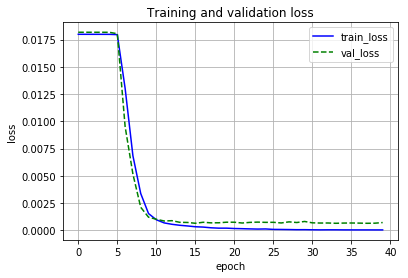

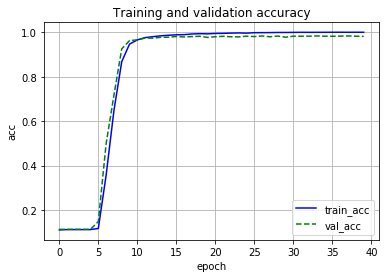

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

# 入力画像のサイズを修正せずにCIFAR10からMNISTに変更したが動作した
# ちょっと意外

train_dataset = torchvision.datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=2)

num_classes = 10

class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()

        # self.featuresはModuleクラスのデフォルトのメンバ変数ではないように見える
        # nn.Sequential:
        # A sequential container. Modules will be added to it in the order they are passed in the constructor.
        # Alternatively, an ordered dict of modules can also be passed in.
        # ネットワークを定義する際にはバッチサイズを無視できるのが地味に助かる
        # というかネットワーク定義時にはバッチサイズは不定のはず
        # https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/container.py
        self.features = nn.Sequential(
            # nn.Conv2d:
            # Applies a 2D convolution over an input signal composed of several input planes.
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        # sequentialの実装:
        # クラスの._modules.values()の使い方は参考になる
        # def forward(self, input):
        #     for module in self._modules.values():
        #         input = module(input)
        #
        # return input
        x = self.features(x)
        # print(x.size()) : torch.Size([128, 256, 1, 1])
        x = x.view(x.size(0), -1)
        # print(x.size()) : torch.Size([128, 256])
        x = self.classifier(x)
        # print(x.size()) : torch.Size([128, 10])
        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 40

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0

    # train
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        # view()での変換をしない
        images, labels = images.to(device), labels.to(device)
        # 傾配を初期化しているのであって、学習すべき重みパラメータの初期化は当然していない
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # val
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            # view()での変換をしない
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = val_acc / len(test_loader.dataset)

    print('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}'
          .format(epoch + 1, num_epochs, i + 1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()